# Final Pipeline: Stage 1 Binary Classification with RoBERTa best hyperparameter + Stage 2 Hierarchical Multi-label Classification

AI was consulted only for debugging support that is error tracing and syntax checks like TypeErrors and import version errors. I knew the concept of stratification, I used ChatGPT-4 to help integrate the correct function call and parameters.  The implementation logic, design, and validation remain entirely my work. I used ChatGPT-4 to help structure this TSNE visualization snippet

###Environmental Setup

In [ ]:
#colab installs
!pip install -q "transformers>=4.44,<5" "datasets>=2.19" accelerate \
                 pandas scikit-learn numpy matplotlib "iterative-stratification>=0.1"

###Imports

In [ ]:
import os, re, ast, json, time, gc, random, subprocess, sys
from datetime import datetime
import numpy as np
import pandas as pd
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    precision_recall_fscore_support, confusion_matrix,
    label_ranking_average_precision_score
)
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
)
from transformers.modeling_outputs import SequenceClassifierOutput

###Stage-1 - (YES/NO) - RoBERTa Final

In [ ]:
# configuration & seeds                                                                                                   ###
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")
#fixed best parameters
CKPT_STAGE1 = "roberta-base"
S1_BEST = dict(lr=1e-5, bsz=16, epochs=6, wd=0.01, warmup=0.06, max_len=256, thr=0.30)



#Stage 2 encoder: Deberta-v3                                                                                               ###
CKPT_STAGE2 = "microsoft/deberta-v3-small"
MAX_LEN_S2  = 256





#functions for cleaning, parsing, normalizing
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\S+","",s)
    s = re.sub(r"[^a-zA-Z0-9\s.,%-]","",s)
    s = re.sub(r"\s+"," ",s).strip()
    return s
def parse_list(x):
    if isinstance(x, list): return x
    if pd.isna(x): return []
    try:
        v = ast.literal_eval(x)
        if isinstance(v, list): return v
    except Exception:
        pass
    return [t.strip() for t in str(x).split(",") if t.strip()]
def l2_normalize_rows(M: np.ndarray, eps=1e-8):
    n = np.linalg.norm(M, axis=1, keepdims=True)
    return M / np.clip(n, eps, None)
def json_safe(obj):
    """Recursively cast to plain Python for json.dump."""
    import numpy as _np, torch as _torch
    if isinstance(obj, (str, int, float, bool)) or obj is None: return obj
    if isinstance(obj, _np.generic): return obj.item()
    if isinstance(obj, _np.ndarray): return obj.tolist()
    if isinstance(obj, _torch.Tensor): return obj.detach().cpu().tolist() if obj.ndim else obj.item()
    if isinstance(obj, dict): return {json_safe(k): json_safe(v) for k,v in obj.items()}
    if isinstance(obj, (list, tuple, set)): return [json_safe(x) for x in obj]
    return str(obj)
df = pd.read_excel("fully_annotated_data.xlsx")
df = df.dropna(subset=["text"]).drop_duplicates(subset=["text"]).copy()
df["label"] = df["label"].str.lower().str.strip()
df["text_clean"] = df["text"].map(clean_text)

#defining Stage2 label space and category-subcategory label taxonomy                                                                                                        ###
PARENTS = ["Environment","Social Capital","Human Capital","Business Model & Innovation","Leadership & Governance"]
label_hierarchy = {
    "Environment": ["GHG Emissions","Air Quality","Energy Management","Water & Wastewater Management",
                    "Waste & Hazardous Materials Management","Ecological Impacts","Unsure (Environment)"],
    "Social Capital": ["Human Rights & Community Relations","Customer Privacy","Data Security","Access & Affordability",
                       "Product Quality & Safety","Customer Welfare","Selling Practices & Product Labeling","Unsure (Social Capital)"],
    "Human Capital": ["Labor Practices","Employee Health & Safety","Employee Engagement, Diversity & Inclusion","Unsure (Human Capital)"],
    "Business Model & Innovation": ["Product Design & Lifecycle Management","Business Model Resilience","Supply Chain Management",
                                    "Materials Sourcing & Efficiency","Physical Impacts of Climate Change","Unsure (Business Model & Innovation)"],
    "Leadership & Governance": ["Business Ethics","Competitive Behavior","Management of Legal & Regulatory Environment",
                                "Critical Incident Risk Management","Systemic Risk Management","Unsure (Leadership & Governance)"],
    "Global Unsure": []
}


#flattening parent+child labels                                                                                                                                         ###
ALL_LABELS = list(dict.fromkeys(PARENTS + [c for subs in label_hierarchy.values() for c in subs]))
label2id = {l:i for i,l in enumerate(ALL_LABELS)}
id2label = {i:l for l,i in label2id.items()}
PARENT_IDS = [label2id[p] for p in PARENTS]
#mapping each child label to its parent ID
child_to_parent = {label2id[c]: label2id[p] for p,subs in label_hierarchy.items() for c in subs}

#binary label mapping
LABELS_BIN = ["no","yes"]
lab2id_bin = {l:i for i,l in enumerate(LABELS_BIN)}
id2lab_bin = {i:l for i,l in enumerate(LABELS_BIN)}
# drop 'tie'
df_bin = df[df["label"].isin(["yes","no"])].copy()



#stratifies split 70/15/15 train/val/test                                                                                                                     ###
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    df_bin["text_clean"], df_bin["label"], test_size=0.30, stratify=df_bin["label"], random_state=SEED
)
X_va, X_te, y_va, y_te = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=SEED
)
def to_hf_bin(Xs, ys):
    return Dataset.from_dict({"text": Xs.tolist(), "label": [lab2id_bin[v] for v in ys]})
train_bin, val_bin, test_bin = to_hf_bin(X_tr,y_tr), to_hf_bin(X_va,y_va), to_hf_bin(X_te,y_te)

# tokenizer + dynamic padding collator
tok1 = AutoTokenizer.from_pretrained(CKPT_STAGE1)
coll1 = DataCollatorWithPadding(tokenizer=tok1)
def tok1_fn(ex): return tok1(ex["text"], truncation=True, max_length=S1_BEST["max_len"])


#mapping over dataset
train_bin = train_bin.map(tok1_fn, batched=True, remove_columns=["text"])
val_bin   = val_bin.map(tok1_fn, batched=True, remove_columns=["text"])
test_bin  = test_bin.map(tok1_fn, batched=True, remove_columns=["text"])





#custom trainer with cross-entropy loss                                                                                                    ###
class CETrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs = model(**inputs)
        loss = nn.functional.cross_entropy(outputs.logits, inputs["labels"])
        return (loss, outputs) if return_outputs else loss
def compute_metrics_bin(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    P, R, F1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": F1}

# for checkpoints
out_dir_s1 = f"models/stage1_yesno_{CKPT_STAGE1.split('/')[-1]}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(out_dir_s1, exist_ok=True)


# initializing RoBERTa classifier
model1 = AutoModelForSequenceClassification.from_pretrained(                                                                            ###
    CKPT_STAGE1, num_labels=2, id2label=id2lab_bin, label2id=lab2id_bin
).to(DEVICE)
args1 = TrainingArguments(
    output_dir=out_dir_s1,
    learning_rate=S1_BEST["lr"],
    per_device_train_batch_size=S1_BEST["bsz"],
    per_device_eval_batch_size=max(32, S1_BEST["bsz"]),
    num_train_epochs=S1_BEST["epochs"],
    weight_decay=S1_BEST["wd"],
    warmup_ratio=S1_BEST["warmup"],
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_steps=50,
    report_to="none",
    fp16=torch.cuda.is_available(),
    seed=SEED, data_seed=SEED,
)

#early stopping                                                                                                                      ###
trainer1 = CETrainer(
    model=model1, args=args1,
    train_dataset=train_bin, eval_dataset=val_bin,
    processing_class=tok1, data_collator=coll1,
    compute_metrics=compute_metrics_bin,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)
print("\n=== Stage-1 training (fixed best hparams) — RoBERTa ===")
t0=time.time(); trainer1.train(); print(f"S1 train time: {time.time()-t0:.1f}s")

#MC-dropout inference to estimate YES probability with uncertainty                                                                      ###
def mc_dropout_yes_probs(mdl, tok, texts, n_passes=12, max_len=256, batch=64):
    was_training = mdl.training
    mdl.train()
    outs=[]
    with torch.no_grad():
        for _ in range(n_passes):
            part=[]
            for i in range(0, len(texts), batch):
                enc = tok(texts[i:i+batch], return_tensors="pt", padding=True, truncation=True, max_length=max_len).to(DEVICE)
                logits = mdl(**enc).logits
                part.append(torch.softmax(logits, dim=1)[:,1].cpu().numpy())
            outs.append(np.concatenate(part,0))
    mdl.train(was_training)
    return np.mean(np.stack(outs,0),0)









#evaluating stage1 performance at fixed threshold on test                                                                                          ###
p_test = mc_dropout_yes_probs(trainer1.model, tok1, X_te.tolist(), n_passes=12, max_len=S1_BEST["max_len"])
yt = np.array([lab2id_bin[v] for v in y_te])
pred = (p_test >= S1_BEST["thr"]).astype(int)
P,R,F1,_ = precision_recall_fscore_support(yt, pred, average='binary', zero_division=0)
print(f"[S1 TEST] thr={S1_BEST['thr']:.2f}  P={P:.3f} R={R:.3f} F1={F1:.3f}")
trainer1.save_model(out_dir_s1); tok1.save_pretrained(out_dir_s1)
with open(os.path.join(out_dir_s1,"deploy_config.json"),"w") as f:
    json.dump({"threshold":S1_BEST["thr"],"mc_passes":12,"max_len":S1_BEST["max_len"],
               "backbone":CKPT_STAGE1,"label2id":lab2id_bin,"id2label":id2lab_bin}, f, indent=2)
print("Saved S1 to:", out_dir_s1)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/1854 [00:00<?, ? examples/s]

Map:   0%|          | 0/397 [00:00<?, ? examples/s]

Map:   0%|          | 0/398 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Stage-1 training (fixed best hparams) — RoBERTa ===


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.408400,0.273445,0.899244,0.800000
2,0.222900,0.224436,0.914358,0.828283
3,0.163600,0.265164,0.921914,0.847291
4,0.124400,0.327638,0.929471,0.864078
5,0.051700,0.385595,0.916877,0.847926
6,0.047800,0.382611,0.919395,0.846154


S1 train time: 159.1s
[S1 TEST] thr=0.30  P=0.837 R=0.870 F1=0.853
Saved S1 to: models/stage1_yesno_roberta-base_20250820_151330


###Stage2: Multilabel Classification (Label-GAT + Contrastive Ablation + KNN Refinement)

In [ ]:
from sklearn.neighbors import NearestNeighbors

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/465 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]


=== Stage-2 variant: none ===


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Lrap,Subset Acc
1,2.858200,1.974220,0.265604,0.071397,0.333313,0.000000
2,1.212100,1.720972,0.383632,0.127050,0.443242,0.009901
3,0.757100,1.572149,0.491909,0.165328,0.571008,0.029703
4,0.463000,1.574907,0.510903,0.169271,0.633534,0.029703
5,0.317100,1.800910,0.585009,0.198731,0.691054,0.108911
6,0.137400,2.016145,0.570902,0.187847,0.712361,0.148515
7,0.100900,2.030284,0.570356,0.174852,0.715773,0.128713
8,0.087100,2.190700,0.608000,0.192549,0.732579,0.178218


Train time (s): 529.2


[VAL]  base: {'micro_f1': 0.5867895545314901, 'macro_f1': 0.21244846730042488, 'lrap': np.float64(0.7325788967105005), 'subset_acc': 0.04950495049504951}  | KNN: {'micro_f1': 0.573268921095008, 'macro_f1': 0.1676728496073573, 'lrap': np.float64(0.7316994645016381), 'subset_acc': 0.07920792079207921}
[TEST] base: {'micro_f1': 0.5546995377503852, 'macro_f1': 0.18138053519739433, 'lrap': np.float64(0.7043256777937128), 'subset_acc': 0.06930693069306931}  | KNN: {'micro_f1': 0.5634266886326195, 'macro_f1': 0.16242228030845188, 'lrap': np.float64(0.7111676835277579), 'subset_acc': 0.10891089108910891}

=== Stage-2 variant: ntxent_any ===


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Lrap,Subset Acc
1,2.945500,2.576586,0.314442,0.072434,0.412194,0.000000
2,1.583200,1.684872,0.394326,0.149593,0.469494,0.000000
3,0.849500,1.616659,0.447447,0.172332,0.548071,0.069307
4,0.594100,1.788189,0.501484,0.164774,0.632129,0.019802
5,0.459200,1.809563,0.548276,0.172834,0.708858,0.128713
6,0.300400,1.930698,0.590674,0.190259,0.715616,0.108911
7,0.249200,2.000134,0.602190,0.193840,0.725436,0.158416
8,0.238200,2.125918,0.626223,0.210399,0.729648,0.198020


Train time (s): 584.7


[VAL]  base: {'micro_f1': 0.632996632996633, 'macro_f1': 0.24463447710031966, 'lrap': np.float64(0.7296475194044872), 'subset_acc': 0.12871287128712872}  | KNN: {'micro_f1': 0.597864768683274, 'macro_f1': 0.18839794001838364, 'lrap': np.float64(0.7345462910770649), 'subset_acc': 0.10891089108910891}
[TEST] base: {'micro_f1': 0.5820642978003384, 'macro_f1': 0.198641636973234, 'lrap': np.float64(0.7002544958741856), 'subset_acc': 0.1188118811881188}  | KNN: {'micro_f1': 0.5985401459854015, 'macro_f1': 0.17792750779413996, 'lrap': np.float64(0.7139194332819195), 'subset_acc': 0.1485148514851485}

=== Stage-2 variant: supcon_any ===


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Lrap,Subset Acc
1,2.949500,2.577867,0.313869,0.072142,0.412194,0.000000
2,1.586200,1.685870,0.393768,0.149436,0.470337,0.000000
3,0.853000,1.617060,0.448795,0.173790,0.546544,0.069307
4,0.597600,1.789811,0.497778,0.162949,0.636373,0.019802
5,0.463400,1.821179,0.547332,0.172442,0.705282,0.128713
6,0.303300,1.940084,0.591696,0.190420,0.716302,0.108911
7,0.250800,2.002315,0.605839,0.195680,0.727015,0.158416
8,0.236700,2.126844,0.624754,0.209226,0.729143,0.198020


Train time (s): 533.8


[VAL]  base: {'micro_f1': 0.6161449752883031, 'macro_f1': 0.24268015934682602, 'lrap': np.float64(0.7291428283917192), 'subset_acc': 0.0891089108910891}  | KNN: {'micro_f1': 0.577391304347826, 'macro_f1': 0.18517758116664146, 'lrap': np.float64(0.7332710010263711), 'subset_acc': 0.0891089108910891}
[TEST] base: {'micro_f1': 0.5790349417637272, 'macro_f1': 0.19879235426196298, 'lrap': np.float64(0.7035240398615513), 'subset_acc': 0.0891089108910891}  | KNN: {'micro_f1': 0.5811051693404634, 'macro_f1': 0.18813392017999064, 'lrap': np.float64(0.7131995398640065), 'subset_acc': 0.09900990099009901}

=== Stage-2 variant: supcon_parent ===


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Lrap,Subset Acc
1,2.949500,2.577867,0.313869,0.072142,0.412194,0.000000
2,1.586200,1.685870,0.393768,0.149436,0.470337,0.000000
3,0.853000,1.617060,0.448795,0.173790,0.546544,0.069307
4,0.597600,1.789811,0.497778,0.162949,0.636373,0.019802
5,0.463400,1.821179,0.547332,0.172442,0.705282,0.128713
6,0.303300,1.940084,0.591696,0.190420,0.716302,0.108911
7,0.250800,2.002315,0.605839,0.195680,0.727015,0.158416
8,0.236700,2.126844,0.624754,0.209226,0.729143,0.198020


Train time (s): 568.5


[VAL]  base: {'micro_f1': 0.6161449752883031, 'macro_f1': 0.24268015934682602, 'lrap': np.float64(0.7291428283917192), 'subset_acc': 0.0891089108910891}  | KNN: {'micro_f1': 0.577391304347826, 'macro_f1': 0.18517758116664146, 'lrap': np.float64(0.7332710010263711), 'subset_acc': 0.0891089108910891}
[TEST] base: {'micro_f1': 0.5790349417637272, 'macro_f1': 0.19879235426196298, 'lrap': np.float64(0.7035240398615513), 'subset_acc': 0.0891089108910891}  | KNN: {'micro_f1': 0.5811051693404634, 'macro_f1': 0.18813392017999064, 'lrap': np.float64(0.7131995398640065), 'subset_acc': 0.09900990099009901}


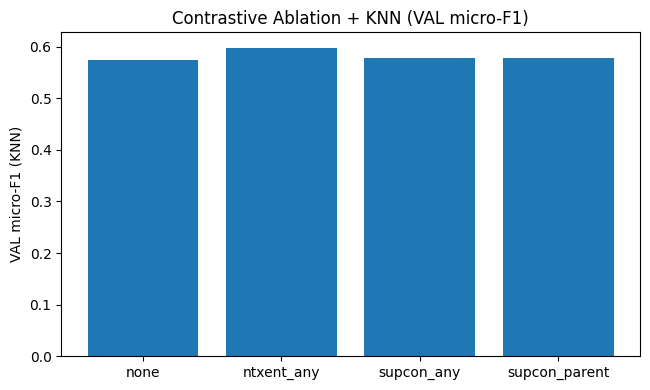

Saved: models/s2_ablation_deberta-v3-small_20250820_151701/ablation_val_micro_f1_knn.png


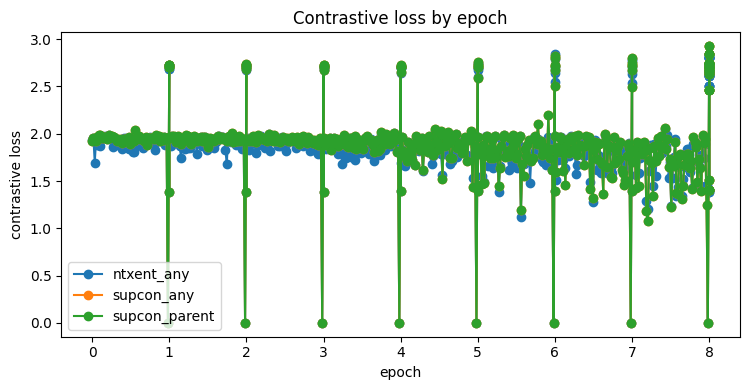

Saved: models/s2_ablation_deberta-v3-small_20250820_151701/contrastive_loss_curves.png


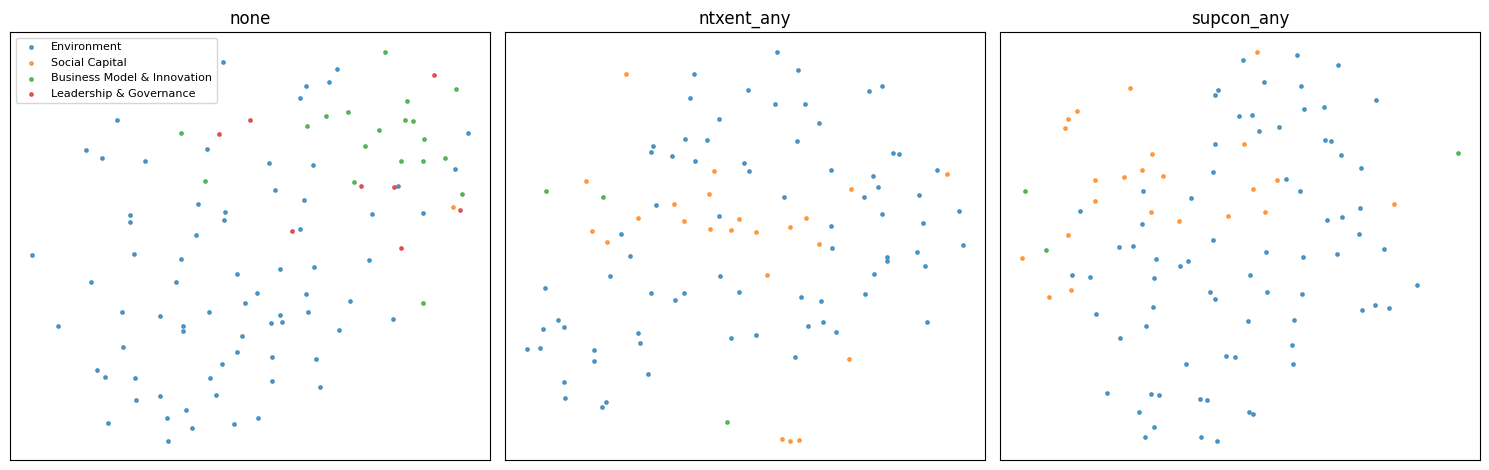

Saved: models/s2_ablation_deberta-v3-small_20250820_151701/tsne_panel_parents.png

Best variant on VAL (KNN): ntxent_any
VAL base: {'micro_f1': 0.632996632996633, 'macro_f1': 0.24463447710031966, 'lrap': np.float64(0.7296475194044872), 'subset_acc': 0.12871287128712872}
VAL KNN : {'micro_f1': 0.597864768683274, 'macro_f1': 0.18839794001838364, 'lrap': np.float64(0.7345462910770649), 'subset_acc': 0.10891089108910891}
TEST base: {'micro_f1': 0.5820642978003384, 'macro_f1': 0.198641636973234, 'lrap': np.float64(0.7002544958741856), 'subset_acc': 0.1188118811881188}
TEST KNN : {'micro_f1': 0.5985401459854015, 'macro_f1': 0.17792750779413996, 'lrap': np.float64(0.7139194332819195), 'subset_acc': 0.1485148514851485}

=== Classification report (TEST, best variant, KNN-refined) ===
                                              precision    recall  f1-score   support

                                 Environment       0.71      0.97      0.82        69
                              Social Capi

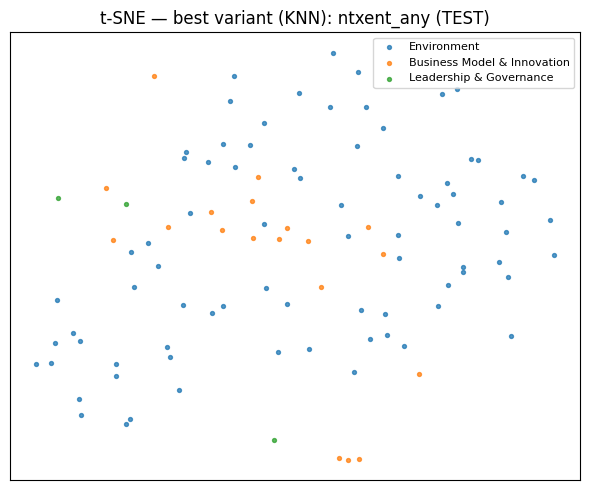

Saved: models/s2_ablation_deberta-v3-small_20250820_151701/tsne_best_ntxent_any_knn.png

All Stage-2 artifacts in: models/s2_ablation_deberta-v3-small_20250820_151701


In [ ]:
# KNN refinement hyperparameters, number of neighbours, blend weight, weight neighbours                                   ###
KNN_K = 15
KNN_ALPHA = 0.35
KNN_POWER = 2.0


def normalize_unsure_row(row):
    cats, subs = parse_list(row.get("Categories", [])), parse_list(row.get("Subcategories", []))
    cat_set = set(cats)
    def fix(lst):
        out=[]
        for lab in lst:
            if str(lab).strip().lower()=="unsure":
                parent = next((p for p in PARENTS if p in cat_set), None)
                out.append(f"Unsure ({parent})" if parent else "Unsure")
            else:
                out.append(lab)
        return out
    row["Categories"] = fix(cats); row["Subcategories"] = fix(subs)
    row["all_labels"] = list(dict.fromkeys(row["Categories"] + row["Subcategories"]))
    return row

df_yes = df[df["label"]=="yes"].copy()
if "Categories" not in df_yes.columns:    df_yes["Categories"] = [[]]*len(df_yes)
if "Subcategories" not in df_yes.columns: df_yes["Subcategories"] = [[]]*len(df_yes)
df_yes = df_yes.apply(normalize_unsure_row, axis=1)

#converting list of labels into multi-hot vector                                                                ###
def to_multihot(lbls):
    v = np.zeros(len(ALL_LABELS), dtype=int)
    for l in lbls:
        if l in label2id: v[label2id[l]] = 1

    for c,p in child_to_parent.items():
        if v[c]==1: v[p]=1
    return v

df_yes["label_vector"] = df_yes["all_labels"].apply(to_multihot)

# multilabel stratified 70/15/15                                                                            ###
X_all = df_yes["text_clean"].values
Y_all = np.stack(df_yes["label_vector"].values)
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=SEED)
tr_idx, tmp_idx = next(msss.split(np.zeros(len(X_all)), Y_all))
msss2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=SEED)
va_rel, te_rel = next(msss2.split(np.zeros(len(tmp_idx)), Y_all[tmp_idx]))
va_idx, te_idx = tmp_idx[va_rel], tmp_idx[te_rel]

train_yes = df_yes.iloc[tr_idx].reset_index(drop=True)
val_yes   = df_yes.iloc[va_idx].reset_index(drop=True)
test_yes  = df_yes.iloc[te_idx].reset_index(drop=True)

def to_hf(df_):
    return Dataset.from_dict({
        "text": df_["text_clean"].tolist(),
        "labels": [list(map(int, v)) for v in df_["label_vector"].tolist()]
    })
train_m, val_m, test_m = to_hf(train_yes), to_hf(val_yes), to_hf(test_yes)

#tokenizer + dynamic padding for Stage-2 encoder                                                                    ###
tok2 = AutoTokenizer.from_pretrained(CKPT_STAGE2)
coll2 = DataCollatorWithPadding(tokenizer=tok2)
def tok2_fn(ex): return tok2(ex["text"], truncation=True, max_length=MAX_LEN_S2)
train_m = train_m.map(tok2_fn, batched=True, remove_columns=["text"])
val_m   = val_m.map(tok2_fn,  batched=True, remove_columns=["text"])
test_m  = test_m.map(tok2_fn, batched=True, remove_columns=["text"])

#handling class imbalance per label by giving rare labels higher weight                                            ###
Ytr = np.stack(train_yes["label_vector"].values); N = len(train_yes); eps=1e-3
pos = Ytr.sum(axis=0); neg = N - pos
pw  = np.clip((neg+eps)/(pos+eps), 1.0, 50.0)
POS_WEIGHT = torch.tensor(pw, dtype=torch.float, device=DEVICE)

# label graph - self attention over label embeddings                                                                           ###
L = len(ALL_LABELS)
A = np.zeros((L, L), dtype=np.float32)
#parent-child symmetric edges
for c,p in child_to_parent.items():
    A[c,p] = 1.0; A[p,c] = 1.0
COOC_TAU = 0.05
cooc = (Ytr.T @ Ytr).astype(np.float32) / float(len(Ytr))
A = np.maximum(A, (cooc >= COOC_TAU).astype(np.float32))
np.fill_diagonal(A, 1.0) #self-connections
A_MASK = torch.tensor(A, dtype=torch.bool, device=DEVICE) #blocking non-edges

#multi-head self attention                                                                                                            ###
class MaskedSelfAttention(nn.Module):
    def __init__(self, dim, heads=8, drop=0.1):
        super().__init__()
        assert dim % heads == 0
        self.h=heads; self.dk=dim//heads
        self.q=nn.Linear(dim,dim,False); self.k=nn.Linear(dim,dim,False); self.v=nn.Linear(dim,dim,False)
        self.o=nn.Linear(dim,dim,False); self.drop=nn.Dropout(drop); self.ln=nn.LayerNorm(dim)
    def forward(self, H, mask):
        L,d=H.shape; R=H
        Q=self.q(H).view(L,self.h,self.dk).transpose(0,1)
        K=self.k(H).view(L,self.h,self.dk).transpose(0,1)
        V=self.v(H).view(L,self.h,self.dk).transpose(0,1)
        S=(Q@K.transpose(1,2))/(self.dk**0.5)
        S=S.masked_fill((~mask)[None,...], float("-inf"))
        A=torch.softmax(S,-1); A=self.drop(A)
        O=(A@V).transpose(0,1).contiguous().view(L,d)
        return self.ln(self.o(O)+R)



#Transformer + label embedding graph-attention                                                                              ###
class ESGGAT(nn.Module):
    def __init__(self, ckpt, num_labels, adj_mask, proj_dim=None, layers=3, heads=8, drop=0.1):
        super().__init__()
        self.enc = AutoModel.from_pretrained(ckpt)
        d = self.enc.config.hidden_size
        self.pdim = proj_dim or d
        self.register_buffer("adj_mask", adj_mask)
        self.label_emb = nn.Parameter(torch.randn(num_labels, d) * 0.02)
        self.gats = nn.ModuleList([MaskedSelfAttention(d, heads, drop) for _ in range(layers)])
        self.text_proj  = nn.Linear(d, self.pdim, False)
        self.label_proj = nn.Linear(d, self.pdim, False)
        self.scale = nn.Parameter(torch.tensor(1.0)) #learnable temperature for similarity
        self.contrast_head = nn.Sequential(nn.Linear(d,d), nn.ReLU(), nn.Linear(d,self.pdim))
        self._zc=None
    def mean_pool(self, last_h, mask):
        m = mask.unsqueeze(-1).float()   ## mask-aware mean pooling over token embeddings
        s = (last_h*m).sum(1)
        c = torch.clamp(m.sum(1), min=1e-6)
        return s/c
    def encode(self, **enc_inputs):
        out = self.enc(**enc_inputs)
        return self.mean_pool(out.last_hidden_state, enc_inputs["attention_mask"])
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, **kw):
        out = self.enc(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sv  = self.mean_pool(out.last_hidden_state, attention_mask)
        H = self.label_emb
        for g in self.gats: H = g(H, self.adj_mask)
        z = self.text_proj(sv); E = self.label_proj(H)
        logits = self.scale * (z @ E.T)
        self._zc = nn.functional.normalize(self.contrast_head(sv), dim=-1) #contrastive embeddings normalized
        return SequenceClassifierOutput(logits=logits)


#label imbalance handling, hierarchy penalty, contrastive loss with multiple modess                                     ###
class BCETrainer(Trainer):
    def __init__(self, pos_weight=None, child_to_parent=None, hier_coef=0.01,
                 contrast_mode="none", contrast_coef=0.10, contrast_temp=0.20, **kw):
        super().__init__(**kw)
        self.pos_weight=pos_weight
        self.child_to_parent=child_to_parent or {}
        self.hier_coef=hier_coef
        self.contrast_mode=contrast_mode
        self.contrast_coef=contrast_coef
        self.contrast_temp=contrast_temp


    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
        logits = outputs.logits
        y = inputs["labels"].float().to(logits.device)

        pw = self.pos_weight
        if isinstance(pw, torch.Tensor) and pw.device != logits.device:
            pw = pw.to(logits.device)

        bce = nn.functional.binary_cross_entropy_with_logits(logits, y, pos_weight=pw)

        sig = torch.sigmoid(logits) #hierarchypenalty
        if self.child_to_parent and self.hier_coef > 0:
            ch = torch.stack([sig[:, c] for c in self.child_to_parent.keys()], dim=1)
            pa = torch.stack([sig[:, p] for p in self.child_to_parent.values()], dim=1)
            hier = (ch - pa).clamp(min=0).mean()
        else:
            hier = torch.tensor(0., device=logits.device)

        #contastive varients
        cont = torch.tensor(0., device=logits.device)
        zc = getattr(model, "_zc", None)
        if self.contrast_mode != "none" and self.contrast_coef > 0 and zc is not None:
            with torch.no_grad():
                if self.contrast_mode in ("ntxent_any","supcon_any"):
                    pos_mask = (y @ y.t()) > 0
                elif self.contrast_mode == "supcon_parent":
                    yp = y[:, PARENT_IDS]
                    pos_mask = (yp @ yp.t()) > 0
                eye = torch.eye(pos_mask.size(0), device=logits.device, dtype=torch.bool)
                pos_mask = pos_mask & (~eye)
            sim  = (zc @ zc.t()) / self.contrast_temp
            sim  = sim - 1e9 * torch.eye(sim.size(0), device=sim.device)
            logp = sim.log_softmax(dim=1)
            if self.contrast_mode == "ntxent_any":
                pos_counts = pos_mask.sum(1).clamp(min=1)
                cont = -(logp[pos_mask].sum() / pos_counts.sum())
            else:
                losses=[]
                for i in range(sim.size(0)):
                    pj = pos_mask[i].nonzero(as_tuple=False).squeeze(1)
                    if pj.numel()==0: continue
                    losses.append(-logp[i, pj].mean())
                cont = torch.stack(losses).mean() if losses else torch.tensor(0., device=sim.device)

        loss = bce + self.hier_coef*hier + self.contrast_coef*cont


        self.log({
            "loss_bce": float(bce.detach().cpu()),
            "loss_hier": float(hier.detach().cpu()),
            "loss_contrast": float(cont.detach().cpu())
        })
        return (loss, outputs) if return_outputs else loss



# Standard multilabel metrics: micro/macro-F1, LRAP, and subset accuracy                                          ###
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1/(1+np.exp(-logits))
    preds = (probs>=0.5).astype(int)
    micro = f1_score(labels, preds, average="micro", zero_division=0)
    macro = f1_score(labels, preds, average="macro", zero_division=0)
    lrap  = label_ranking_average_precision_score(labels, probs)
    subset= accuracy_score(labels, preds)
    return {"micro_f1":micro, "macro_f1":macro, "lrap":lrap, "subset_acc":subset}


#temp scaling on validation logits                                                                                  ###
def calibrate_temperature(val_logits, val_true, max_iter=50):
    z = torch.tensor(val_logits, dtype=torch.float32, device=DEVICE)
    y = torch.tensor(val_true,   dtype=torch.float32, device=DEVICE)
    logT = torch.nn.Parameter(torch.zeros((), device=DEVICE))
    opt = torch.optim.Adam([logT], lr=0.05)
    for _ in range(max_iter):
        opt.zero_grad(); T = torch.exp(logT)+1e-6
        loss = nn.functional.binary_cross_entropy_with_logits(z/T, y)
        loss.backward(); opt.step()
    return float(torch.exp(logT).detach().cpu())

def enforce_parent(vec):
    v = vec.copy()
    for c,p in child_to_parent.items():
        if v[c]==1: v[p]=1
    return v

#training a single variant, adding KNN refinement                                                                                 ##
def train_variant(contrast_mode, out_root):
    out_dir = os.path.join(out_root, f"s2_{contrast_mode}_{datetime.now().strftime('%H%M%S')}")
    os.makedirs(out_dir, exist_ok=True)

#model building                                                                                                                   ###
    model = ESGGAT(CKPT_STAGE2, L, A_MASK, proj_dim=None, layers=3, heads=8, drop=0.1).to(DEVICE)
    args = TrainingArguments(
        output_dir=out_dir,
        learning_rate=2e-5, per_device_train_batch_size=8, per_device_eval_batch_size=16,
        num_train_epochs=8, weight_decay=0.01, warmup_ratio=0.06,
        eval_strategy="epoch", save_strategy="epoch", save_total_limit=1,
        load_best_model_at_end=True, metric_for_best_model="micro_f1", greater_is_better=True,
        logging_steps=50, report_to=[], seed=SEED, data_seed=SEED, fp16=torch.cuda.is_available(),
        remove_unused_columns=False, label_names=["labels"]
    )
    trainer = BCETrainer(
        model=model, args=args, train_dataset=train_m, eval_dataset=val_m,
        processing_class=tok2, data_collator=coll2, compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        pos_weight=POS_WEIGHT, child_to_parent=child_to_parent, hier_coef=0.01,
        contrast_mode=contrast_mode, contrast_coef=(0.10 if contrast_mode!="none" else 0.0), contrast_temp=0.20
    )
    print(f"\n=== Stage-2 variant: {contrast_mode} ===")
    t0 = time.time(); trainer.train(); print("Train time (s):", round(time.time()-t0,1))


# calibration + per-label thr on VAL
    val_logits = trainer.predict(val_m).predictions
    val_true   = np.stack(val_yes["label_vector"].values)
    T = calibrate_temperature(val_logits, val_true, max_iter=50)
    val_probs_base = 1/(1+np.exp(-(val_logits/T)))

#sweeping per-label thresholds and picking best f1 on val                                                       ###
    thrs = np.linspace(0.05, 0.95, 19)
    thr_vec = np.full(val_true.shape[1], 0.5, dtype=np.float32); min_support=5
    for j in range(val_true.shape[1]):
        yj = val_true[:,j]
        if yj.sum() < min_support: continue
        pj = val_probs_base[:,j]; best_t, best_f = 0.5, -1
        for t in thrs:
            f1 = f1_score(yj, (pj>=t).astype(int), zero_division=0)
            if f1>best_f: best_f, best_t = f1, t
        thr_vec[j] = best_t
    for c,p in child_to_parent.items():
        thr_vec[p] = min(thr_vec[p], thr_vec[c])

#knn refinement helper functions                                                                                 ###
    def _encode_texts(ds, batch=32):
        mdl = trainer.model; mdl.eval()
        no_label = ds.remove_columns([c for c in ds.column_names if c=="labels"])
        loader = DataLoader(no_label, batch_size=batch, shuffle=False, collate_fn=coll2)
        Z=[]
        with torch.inference_mode():
            for b in loader:
                b = {k:v.to(DEVICE) for k,v in b.items()}
                sent = mdl.encode(**{k: b[k] for k in ["input_ids","attention_mask"] if k in b})
                Z.append(sent.cpu())
        return l2_normalize_rows(torch.cat(Z,0).numpy())

#KNN on train embeddings                                                                                                 ###
    Z_train = _encode_texts(train_m)
    nn_k = min(KNN_K, len(Z_train))
    knn = NearestNeighbors(n_neighbors=nn_k, metric="cosine", algorithm="brute").fit(Z_train)
    Y_train = np.stack(train_yes["label_vector"].values).astype(np.float32)

    def refine_with_knn(ds, base_probs):
        Zq = _encode_texts(ds)
        dists, idxs = knn.kneighbors(Zq, n_neighbors=nn_k, return_distance=True)

        w = np.clip(1.0 - dists, 0.0, 1.0) ** KNN_POWER
        w_sum = np.clip(w.sum(axis=1, keepdims=True), 1e-6, None)
        w = w / w_sum
        neigh_prior = np.einsum("nk,nkl->nl", w, Y_train[idxs])
        refined = (1.0 - KNN_ALPHA)*base_probs + KNN_ALPHA*neigh_prior
        return np.clip(refined, 0.0, 1.0)


#evaluating on a split with and without knn refinement - applying temp, per label thresholds                                        ###
    def eval_split(ds, true_bin, use_knn=False, base_probs=None):
        logits = trainer.predict(ds).predictions
        probs  = 1/(1+np.exp(-(logits/T)))
        if use_knn:
            probs_ref = refine_with_knn(ds, probs if base_probs is None else base_probs)
            preds_ref = (probs_ref >= thr_vec[None,:]).astype(int)
            preds_ref = np.stack([enforce_parent(p) for p in preds_ref])
            micro = f1_score(true_bin, preds_ref, average="micro", zero_division=0)
            macro = f1_score(true_bin, preds_ref, average="macro", zero_division=0)
            lrap  = label_ranking_average_precision_score(true_bin, probs_ref)
            subset= accuracy_score(true_bin, preds_ref)
            return dict(micro_f1=micro, macro_f1=macro, lrap=lrap, subset_acc=subset), probs_ref, preds_ref
        else:
            preds = (probs >= thr_vec[None,:]).astype(int)
            preds = np.stack([enforce_parent(p) for p in preds])
            micro = f1_score(true_bin, preds, average="micro", zero_division=0)
            macro = f1_score(true_bin, preds, average="macro", zero_division=0)
            lrap  = label_ranking_average_precision_score(true_bin, probs)
            subset= accuracy_score(true_bin, preds)
            return dict(micro_f1=micro, macro_f1=macro, lrap=lrap, subset_acc=subset), probs, preds

# evaluating base + KNN-refined on val/test                                                                                                ###
    Yv = np.stack(val_yes["label_vector"].values)
    Yt = np.stack(test_yes["label_vector"].values)
    val_metrics,  val_probs,  val_preds  = eval_split(val_m,  Yv, use_knn=False)
    test_metrics, test_probs, test_preds = eval_split(test_m, Yt, use_knn=False)
    val_knn_metrics,  val_probs_knn,  val_preds_knn  = eval_split(val_m,  Yv, use_knn=True, base_probs=val_probs)
    test_knn_metrics, test_probs_knn, test_preds_knn = eval_split(test_m, Yt, use_knn=True, base_probs=test_probs)
    print("[VAL]  base:", val_metrics,  " | KNN:", val_knn_metrics)
    print("[TEST] base:", test_metrics, " | KNN:", test_knn_metrics)





# saving weights for analysis                                                                                                                    ###
    torch.save(model.state_dict(), os.path.join(out_dir, "pytorch_model.bin"))
    tok2.save_pretrained(out_dir)
    meta = {
        "backbone": CKPT_STAGE2,
        "ALL_LABELS": ALL_LABELS,
        "id2label": {int(k): v for k,v in id2label.items()},
        "child_to_parent": {int(k): int(v) for k,v in child_to_parent.items()},
        "temperature": float(T),
        "thr_vec": thr_vec.tolist(),
        "contrast_mode": contrast_mode,
        "graph": {
            "L": int(L),
            "adj_edges": [(int(i), int(j)) for i,j in zip(*np.where(A>0.5))],
            "cooc_tau": float(COOC_TAU),
        },
        "knn": {"k": int(nn_k), "alpha": float(KNN_ALPHA), "power": float(KNN_POWER)}
    }
    with open(os.path.join(out_dir, "meta.json"), "w") as f:
        json.dump(json_safe(meta), f, indent=2)



#log history                                                                                                                                                ###
    hist = [
        {"epoch": float(h["epoch"]),
         **({k: float(h[k]) for k in h.keys() if k.startswith("loss_") or k.startswith("eval_") and isinstance(h[k], (int,float))})}
        for h in trainer.state.log_history if "epoch" in h
    ]

    return (out_dir, trainer,
            val_metrics, test_metrics, test_probs, test_preds,
            val_knn_metrics, test_knn_metrics, test_probs_knn, test_preds_knn,
            T, thr_vec, hist)





#ablation - contrastive variants to compare where "none" is the control                                                     ###
OUT_ROOT = f"models/s2_ablation_{CKPT_STAGE2.split('/')[-1]}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(OUT_ROOT, exist_ok=True)

ABLATE = ["none","ntxent_any","supcon_any","supcon_parent"]
results = []
for mode in ABLATE:
    (odir, tr, vm, tm, tprob, tpred,
     vm_knn, tm_knn, tprob_knn, tpred_knn,
     T, thr, hist) = train_variant(mode, OUT_ROOT)
    results.append(dict(
        mode=mode, out_dir=odir, trainer=tr,
        val=vm, test=tm, test_probs=tprob, test_preds=tpred,
        val_knn=vm_knn, test_knn=tm_knn, test_probs_knn=tprob_knn, test_preds_knn=tpred_knn,
        T=T, thr=thr, log=hist
    ))
    gc.collect();
    if torch.cuda.is_available(): torch.cuda.empty_cache()


#plots: VAL micro-F1 (KNN), contrastive curves, t-SNE                                                                               ###
names = [r["mode"] for r in results]
vals  = [r.get("val_knn", r["val"])["micro_f1"] for r in results]
plt.figure(figsize=(6.6,4)); plt.bar(names, vals)
plt.title("Contrastive Ablation + KNN (VAL micro-F1)"); plt.ylabel("VAL micro-F1 (KNN)")
plt.tight_layout()
bar_path = os.path.join(OUT_ROOT, "ablation_val_micro_f1_knn.png"); plt.savefig(bar_path, dpi=150); plt.show()
print("Saved:", bar_path)



#contrastive loss across epochs
plt.figure(figsize=(7.6,4))
for r in results:
    if r["mode"]=="none": continue
    epochs = [h["epoch"] for h in r["log"] if "loss_contrast" in h]
    losses = [h["loss_contrast"] for h in r["log"] if "loss_contrast" in h]
    if epochs: plt.plot(epochs, losses, marker="o", label=r["mode"])
plt.xlabel("epoch"); plt.ylabel("contrastive loss"); plt.title("Contrastive loss by epoch")
plt.legend(); plt.tight_layout()
cl_path = os.path.join(OUT_ROOT, "contrastive_loss_curves.png"); plt.savefig(cl_path, dpi=150); plt.show()
print("Saved:", cl_path)

variant_map = {r["mode"]: r for r in results}
TSNE_PLOTS_FOR = ["none","ntxent_any","supcon_any"]
#encode dataset split                                                                                                              ###
def encode_texts(trainer, ds, batch=32):
    model = trainer.model; model.eval()
    no_label = ds.remove_columns([c for c in ds.column_names if c=="labels"])
    loader = DataLoader(no_label, batch_size=batch, shuffle=False, collate_fn=coll2)
    Z=[]
    with torch.inference_mode():
        for batch in loader:
            batch = {k:v.to(DEVICE) for k,v in batch.items()}
            sent = model.encode(**{k: batch[k] for k in ["input_ids","attention_mask"] if k in batch})
            Z.append(sent.cpu())
    return l2_normalize_rows(torch.cat(Z,0).numpy())



#if any parents pass threshold, choose the highest-scoring among them, otherwise choose the max-scoring parent
def predict_parent_labels(probs, thr_vec):
    preds = (probs >= thr_vec[None,:]).astype(int)
    parent_scores  = probs[:, PARENT_IDS]
    parent_present = preds[:, PARENT_IDS]
    picks=[]
    for i in range(probs.shape[0]):
        if parent_present[i].any():
            k = np.where(parent_present[i]==1)[0]
            j_local = k[np.argmax(parent_scores[i][k])]
            picks.append(PARENT_IDS[j_local])
        else:
            picks.append(PARENT_IDS[int(np.argmax(parent_scores[i]))])
    return np.array(picks)


fig, axes = plt.subplots(1, 3, figsize=(15,4.8))
for ax, mode in zip(axes, TSNE_PLOTS_FOR):
    r = variant_map[mode]
    Z = encode_texts(r["trainer"], test_m)
    Z2 = TSNE(n_components=2, perplexity=30, init="random", learning_rate="auto", random_state=SEED).fit_transform(Z)
    parents_pred = predict_parent_labels(r["test_probs"], r["thr"])
    for pid in PARENT_IDS:
        pts = Z2[parents_pred==pid]
        if len(pts)==0: continue
        ax.scatter(pts[:,0], pts[:,1], s=6, alpha=0.7, label=id2label[pid])
    ax.set_title(mode); ax.set_xticks([]); ax.set_yticks([])
    if mode==TSNE_PLOTS_FOR[0]: ax.legend(loc="best", fontsize=8)
plt.tight_layout()
tsne_panel_path = os.path.join(OUT_ROOT, "tsne_panel_parents.png"); plt.savefig(tsne_panel_path, dpi=150); plt.show()
print("Saved:", tsne_panel_path)


#best variant, classification report, focused t-SNE (KNN-refined)                                                                  ###
best = max(results, key=lambda r: r.get("val_knn", r["val"])["micro_f1"])
print("\nBest variant on VAL (KNN):", best["mode"])
print("VAL base:", best["val"])
print("VAL KNN :", best["val_knn"])
print("TEST base:", best["test"])
print("TEST KNN :", best["test_knn"])

Y_true_test = np.stack(test_yes["label_vector"].values)
Y_pred_test = best.get("test_preds_knn", best["test_preds"])
print("\n=== Classification report (TEST, best variant, KNN-refined) ===")
print(classification_report(Y_true_test, Y_pred_test, target_names=ALL_LABELS, zero_division=0))




#t-SNE for the best variant                                                                                                                         ###
Z_best = encode_texts(best["trainer"], test_m)
Z2_best = TSNE(n_components=2, perplexity=30, init="random", learning_rate="auto", random_state=SEED).fit_transform(Z_best)
probs_for_colors = best.get("test_probs_knn", best["test_probs"])
parents_best = predict_parent_labels(probs_for_colors, best["thr"])
plt.figure(figsize=(6,5))
for pid in PARENT_IDS:
    pts = Z2_best[parents_best==pid]
    if len(pts)==0: continue
    plt.scatter(pts[:,0], pts[:,1], s=8, alpha=0.75, label=id2label[pid])



plt.title(f"t-SNE — best variant (KNN): {best['mode']} (TEST)")
plt.xticks([]); plt.yticks([]); plt.legend(fontsize=8)
plt.tight_layout()
best_tsne_path = os.path.join(OUT_ROOT, f"tsne_best_{best['mode']}_knn.png")
plt.savefig(best_tsne_path, dpi=150); plt.show()
print("Saved:", best_tsne_path)
print("\nAll Stage-2 artifacts in:", OUT_ROOT)
